**Google Colab Spec. Check**

In [1]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install -q gputil

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 12.8 GB  | Proc size: 159.7 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [2]:
!git clone https://github.com/rekalantar/LiverSegmentation

Cloning into 'LiverSegmentation'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 82 (delta 2), reused 15 (delta 2), pack-reused 65
Unpacking objects: 100% (82/82), done.
Checking out files: 100% (49/49), done.


**Data Preprocessing**

In [3]:
import os
import io
import glob
import nibabel
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
from skimage.exposure import rescale_intensity
from skimage.segmentation import mark_boundaries

In [4]:
data_path = '/content/LiverSegmentation/dataset'

In [5]:
#@title Load Images and Masks
def load_images_and_masks(path, mode):

  data_path = os.path.join(path, mode)
  file_names = os.listdir(data_path)

  image_names = [img for img in file_names if img.split('_')[-1].split('.nii')[0] == 'orig']
  image_names.sort()

  mask_names = [mask for mask in file_names if mask.split('_')[-1].split('.nii')[0] == 'liver']
  mask_names.sort()

  print(f"[INFO] Loading {mode} images and masks ...")

  images, masks = [], []
  for orig, liver in zip(image_names, mask_names):

    # Load 3D images and masks
    image = nibabel.load(os.path.join(data_path, orig)) 
    mask = nibabel.load(os.path.join(data_path, liver))
    
    for k in range(mask.shape[2]):
      
        # Reduce size by a factor of two for each slice in the z-direction for faster training
        image_2d = np.array(image.get_fdata()[::2, ::2, k]) 
        mask_2d = np.array(mask.get_fdata()[::2, ::2, k]) 

        if len(np.unique(mask_2d)) != 1:
          # Rotate 90 deg to correct the orientation and append the 2D images and masks to separate arrays
          image_2d = np.rot90(image_2d,axes=(-2,-1))
          images.append(image_2d)

          mask_2d = np.rot90(mask_2d,axes=(-2,-1))
          masks.append(mask_2d)

  def normalise_unet(x):
    '''
    Normalisation of images for UNet training: range [0,1]
    '''
    for i in range(len(x)):
        x[i] = (x[i] - np.min(x[i]))/(np.max(x[i])-np.min(x[i]))
    return x          

  def preprocess_and_normalise(images):
    norm_imgs = normalise_unet(images)
    norm_imgs = np.array(norm_imgs)
    norm_imgs = np.expand_dims(norm_imgs, axis = -1) # Expected tf.keras model input = (batch size, img_dim, img_dim, img_channel)
    return norm_imgs

  print('[INFO] Normalizing images to range [0,1] ...\n')
  images = preprocess_and_normalise(images)
  masks = preprocess_and_normalise(masks)

  # print(f"[INFO] Saving {mode} images and masks to .npy files ...") 
  # np.save(f'{mode}_images.npy', images )
  # np.save(f'{mode}_masks.npy', masks)

  return images, masks

In [ ]:
train_images, train_masks = load_images_and_masks(data_path, mode = 'train')
test_images, test_masks = load_images_and_masks(data_path, mode = 'test')

[INFO] Loading train images and masks ...
[INFO] Normalizing images to range [0,1] ...
[INFO] Saving train images and masks to .npy files ...

[INFO] Loading test images and masks ...
[INFO] Normalizing images to range [0,1] ...
[INFO] Saving test images and masks to .npy files ...



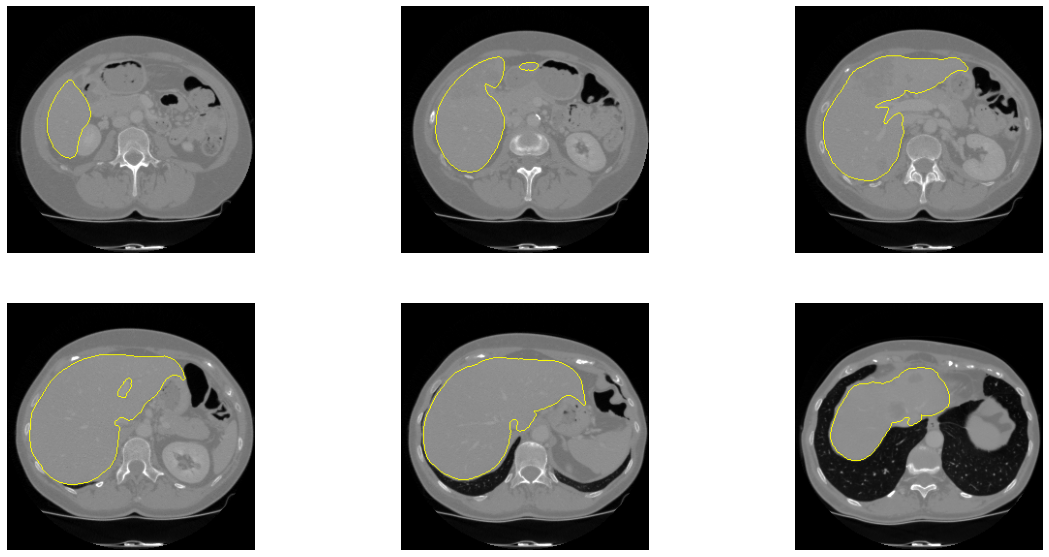

In [ ]:
plt.figure(figsize=(20,10))
for i in range(1, 7):
    plt.subplot(2, 3, i)
    temp_img = train_images[15*i,:,:,0]
    temp_img = rescale_intensity(temp_img,out_range=(0,1))
    temp_mask = train_masks[15*i,:,:,0].astype('uint8')
    plt.imshow(mark_boundaries(temp_img,temp_mask))
    plt.axis('OFF')

**Model Training**

In [ ]:
import tensorflow as tf
from tensorflow import keras

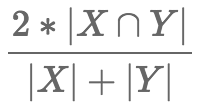

In [4]:
Image('/content/LiverSegmentation/DCE_eq.png')

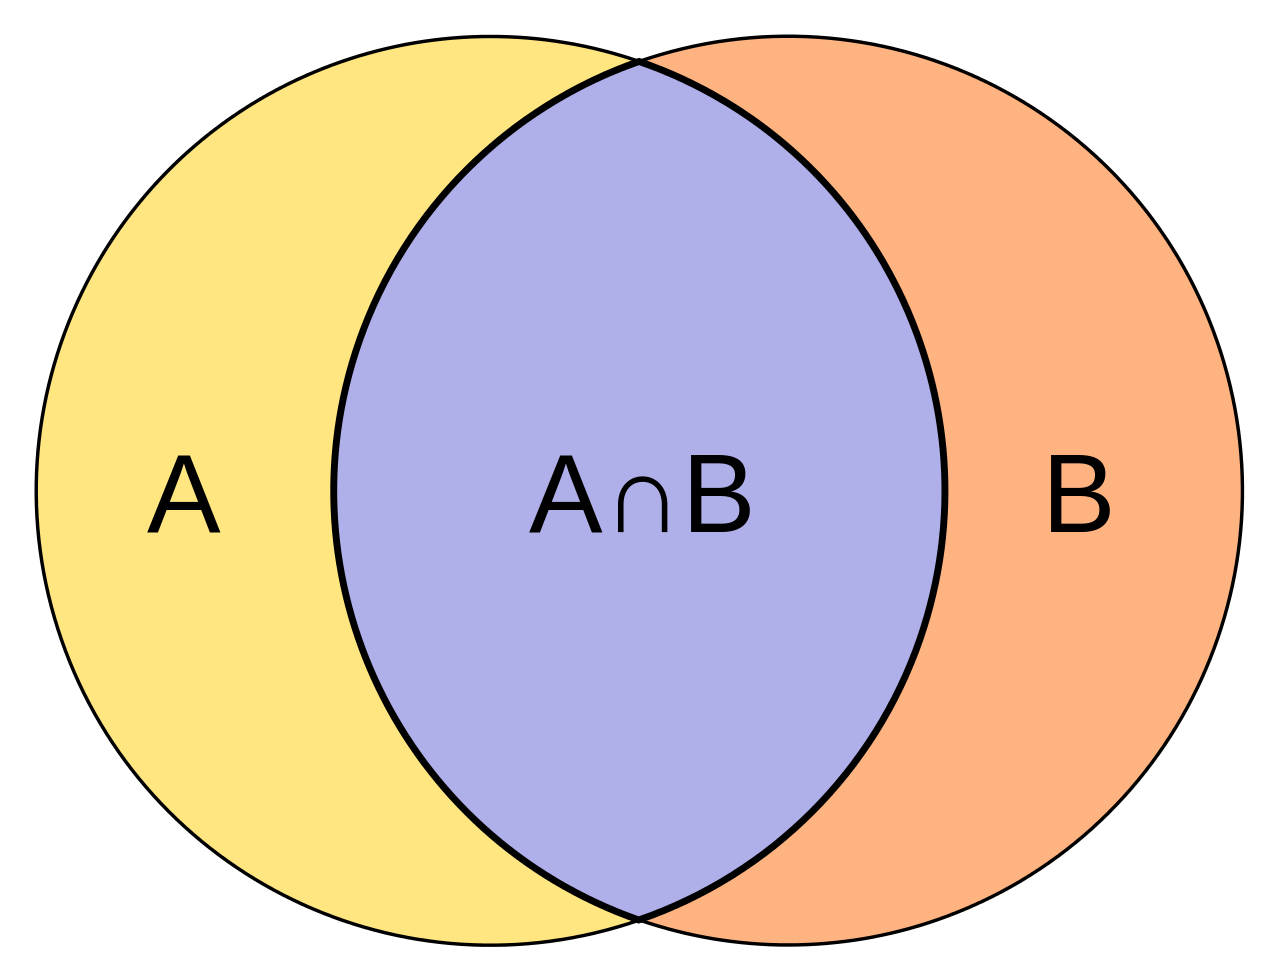

In [5]:
Image('/content/LiverSegmentation/DCE.png')

In [ ]:
#@title Define Loss Function
def dice_coef(y_true, y_pred, smooth=1.):
  """
  Dice = (2*|X & Y|)/ (|X|+ |Y|)
        =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
  ref: https://arxiv.org/pdf/1606.04797v1.pdf
  """
  y_true_f = tf.keras.backend.flatten(y_true)
  y_pred_f = tf.keras.backend.flatten(y_pred)
  intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
    

Build UNet Model

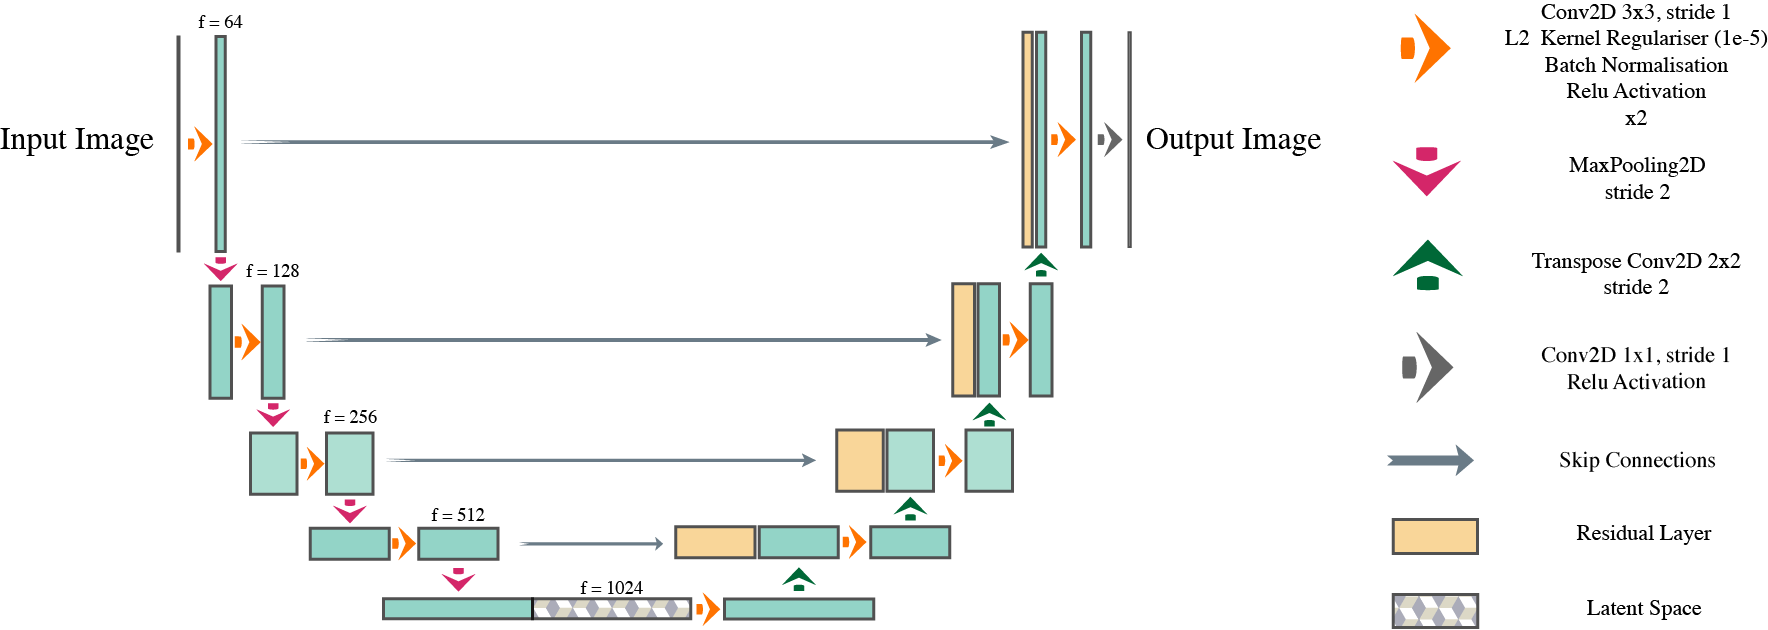

In [4]:
Image('/content/LiverSegmentation/unet.png')

In [ ]:
def UNet(img_size=(256,256,1)):
    print(f"[INFO] Building model with input shape {img_size} ...")

    print()
    inputs = tf.keras.Input(img_size)
    print(inputs.shape)

    print()
    conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    # conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    print("\t Conv ->", conv1.shape)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    print("\t Pool ->", pool1.shape)

    print()
    conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    # conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    print("\t\t Conv ->", conv2.shape)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    print("\t\t Pool ->", pool2.shape)

    print()
    conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    # conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    print("\t\t\t Conv ->", conv3.shape)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    print("\t\t\t Pool ->", pool3.shape)

    print()
    conv4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    # conv4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    print("\t\t\t\t Conv ->", conv4.shape)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    print("\t\t\t\t Pool ->", pool4.shape)

    print()
    conv5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    # conv5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    print("\t\t\t\t\t Bridge Conv ->", conv5.shape)

    print()
    up6 = tf.concat([tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    print("\t\t\t\t Concat ->", up6.shape)
    conv6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    # conv6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    print("\t\t\t\t Conv ->", conv6.shape)

    print()
    up7 = tf.concat([tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    print("\t\t\t Concat ->", up7.shape)
    conv7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    # conv7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    print("\t\t\t Conv ->", conv7.shape)

    print()
    up8 = tf.concat([tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    print("\t\t Concat ->", up8.shape)
    conv8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    # conv8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    print("\t\t Conv ->", conv8.shape)

    print()
    up9 = tf.concat([tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    print("\t Concat ->", up9.shape)
    conv9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    # conv9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    print("\t Conv ->", conv9.shape)

    print()
    conv10 = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    print("Conv ->", conv10.shape)

    model = tf.keras.models.Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss='bce', metrics=[dice_coef])

    return model

In [ ]:
model = UNet()

[INFO] Building model with input shape (256, 256, 1) ...

(None, 256, 256, 1)

	 Conv -> (None, 256, 256, 32)
	 Pool -> (None, 128, 128, 32)

		 Conv -> (None, 128, 128, 64)
		 Pool -> (None, 64, 64, 64)

			 Conv -> (None, 64, 64, 128)
			 Pool -> (None, 32, 32, 128)

				 Conv -> (None, 32, 32, 256)
				 Pool -> (None, 16, 16, 256)

					 Bridge Conv -> (None, 16, 16, 512)

				 Concat -> (None, 32, 32, 512)
				 Conv -> (None, 32, 32, 256)

			 Concat -> (None, 64, 64, 256)
			 Conv -> (None, 64, 64, 128)

		 Concat -> (None, 128, 128, 128)
		 Conv -> (None, 128, 128, 64)

	 Concat -> (None, 256, 256, 64)
	 Conv -> (None, 256, 256, 32)

Conv -> (None, 256, 256, 1)


In [ ]:
# Callback for saving the best weights after training
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

In [ ]:
resutls = model.fit(train_images, train_masks, batch_size=10, epochs=20, verbose=1, shuffle=True,
              validation_split=0.2,
              callbacks=[model_checkpoint])

Epoch 1/20
133/133 [==============================] - 21s 155ms/step - loss: 0.2114 - dice_coef: 0.2766 - val_loss: 0.1214 - val_dice_coef: 0.4125
Epoch 2/20
133/133 [==============================] - 20s 151ms/step - loss: 0.1272 - dice_coef: 0.4676 - val_loss: 0.1124 - val_dice_coef: 0.4274
Epoch 3/20
133/133 [==============================] - 20s 152ms/step - loss: 0.0741 - dice_coef: 0.6722 - val_loss: 0.0616 - val_dice_coef: 0.6344
Epoch 4/20
133/133 [==============================] - 20s 151ms/step - loss: 0.0502 - dice_coef: 0.7812 - val_loss: 0.0842 - val_dice_coef: 0.6308
Epoch 5/20
133/133 [==============================] - 20s 152ms/step - loss: 0.0327 - dice_coef: 0.8592 - val_loss: 0.0709 - val_dice_coef: 0.6685
Epoch 6/20
133/133 [==============================] - 20s 153ms/step - loss: 0.0227 - dice_coef: 0.9020 - val_loss: 0.0605 - val_dice_coef: 0.7556
Epoch 7/20
133/133 [==============================] - 20s 152ms/step - loss: 0.0175 - dice_coef: 0.9242 - val_loss: 0.

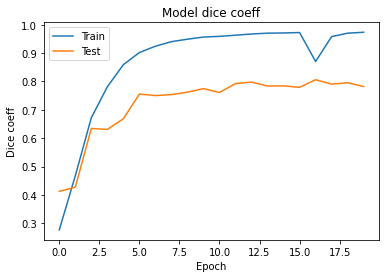

In [ ]:
plt.plot(resutls.history['dice_coef'])
plt.plot(resutls.history['val_dice_coef'])
plt.title('Model dice coeff')
plt.ylabel('Dice coeff')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Prediction and Visualisation**

In [ ]:
print("[INFO] Making predictions on test images ...")
predictions = model.predict(test_images, verbose=1)

orig, preds = [], []
for i in range(len(test_images)):
    temp_img = rescale_intensity(test_images[i,:,:,0],out_range=(0,1))
    orig_mask = (test_masks[i,:,:,0]).astype('uint8')
    orig.append(mark_boundaries(temp_img,orig_mask))
    preds.append(mark_boundaries(temp_img,predictions[i,:,:,0].astype('uint8')))

[INFO] Making predictions on test images ...
13/13 [==============================] - 3s 199ms/step


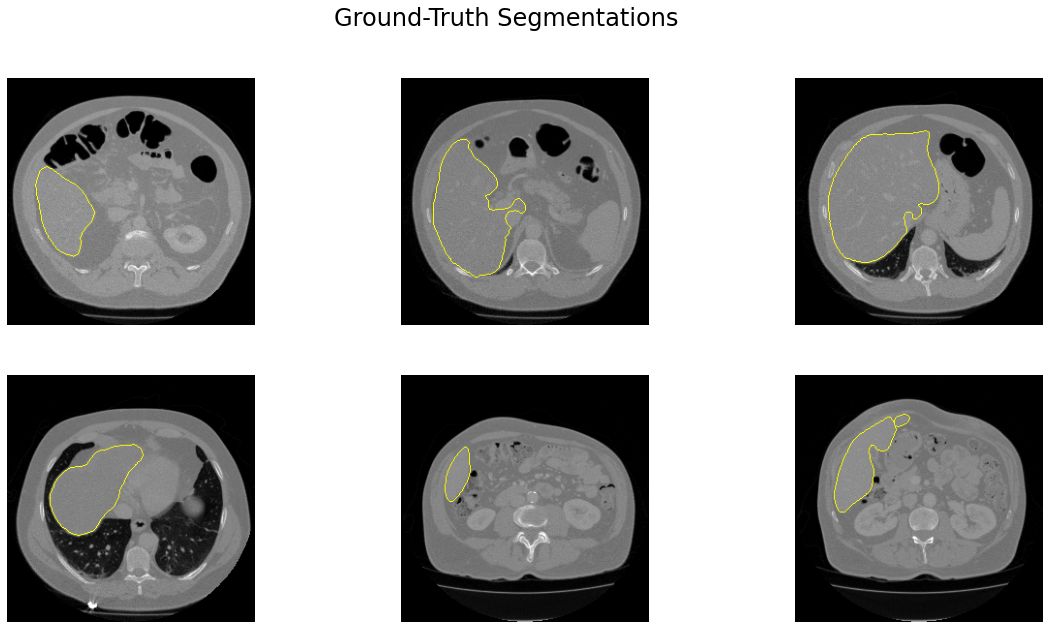

In [ ]:
# Ground truth test examples
plt.figure(figsize=(20,10))
plt.suptitle('Ground-Truth Segmentations', fontsize=24)
for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.imshow(orig[25*i])
    plt.axis('OFF')

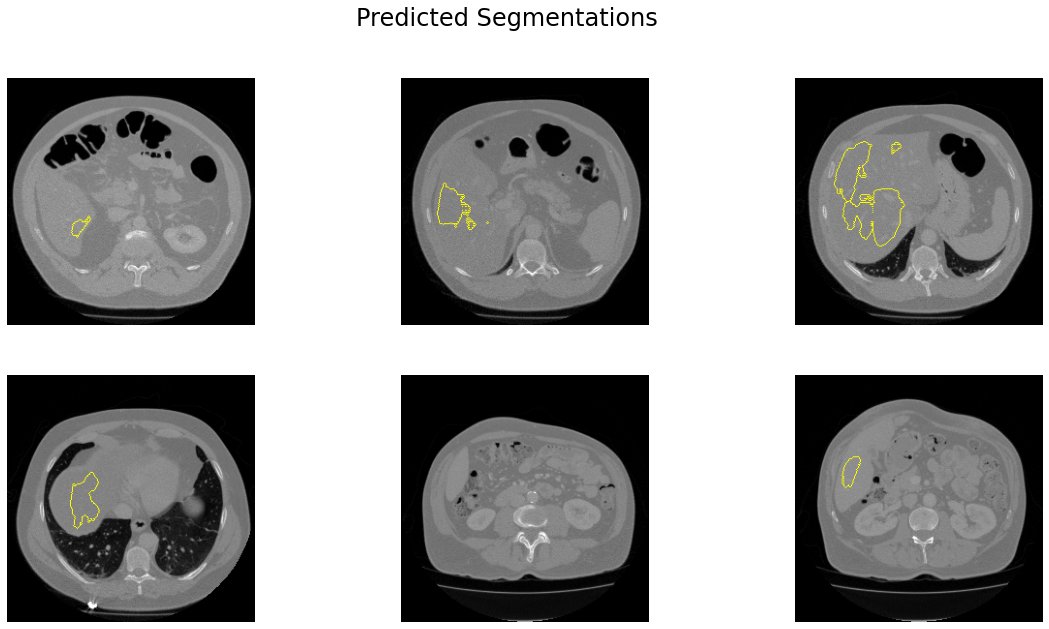

In [ ]:
# Predicted segmentations from the test set
plt.figure(figsize=(20,10))
plt.suptitle('Predicted Segmentations', fontsize=24)
for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.imshow(preds[25*i])
    plt.axis('OFF')